# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import math
import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### The August birthday problem

This article:

[Attention Deficit–Hyperactivity Disorder and Month of School Enrollment](https://www.nejm.org/doi/10.1056/NEJMoa1806828)

Finds:

>The rate of claims-based ADHD diagnosis among children in states with a September 1 cutoff was 85.1 per 10,000 children (309 cases among 36,319 children; 95% confidence interval [CI], 75.6 to 94.2) among those born in August and 63.6 per 10,000 children (225 cases among 35,353 children; 95% CI, 55.4 to 71.9) among those born in September, an absolute difference of 21.5 per 10,000 children (95% CI, 8.8 to 34.0); the corresponding difference in states without the September 1 cutoff was 8.9 per 10,000 children (95% CI, −14.9 to 20.8). The rate of ADHD treatment was 52.9 per 10,000 children (192 of 36,319 children; 95% CI, 45.4 to 60.3) among those born in August and 40.4 per 10,000 children (143 of 35,353 children; 95% CI, 33.8 to 47.1) among those born in September, an absolute difference of 12.5 per 10,000 children (95% CI, 2.43 to 22.4). These differences were not observed for other month-to-month comparisons, nor were they observed in states with non-September cutoff dates for starting kindergarten. In addition, in states with a September 1 cutoff, no significant differences between August-born and September-born children were observed in rates of asthma, diabetes, or obesity.

It includes this figure:

![](https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20181123/images/img_xlarge/nejmoa1806828_f1.jpeg)

However, there is an error in this figure, confirmed by personal correspondence:

>The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).


Based on this corrected data, what can we say about the probability of diagnosis as a function of birth month?

What can we say about the rate of misdiagnosis?

Here's the data from the table.

In [2]:
totals = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

diagnosed = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

array([265, 280, 307, 312, 317, 287, 320, 309, 225, 240, 232, 243])

I'll roll the data so September comes first.

In [3]:
totals = np.roll(totals, -8)
diagnosed = np.roll(diagnosed, -8)

array([225, 240, 232, 243, 265, 280, 307, 312, 317, 287, 320, 309])

Here are the diagnosis rates, which we can check against the rates in the table.

In [4]:
rates = diagnosed / totals * 10000
np.round(rates, 1)

array([63.6, 69.8, 74.2, 76.9, 81.1, 89.6, 89.2, 90.3, 90.6, 83.4, 87.5,
       85.1])

Here's what the rates look like as a function of months after the September cutoff.

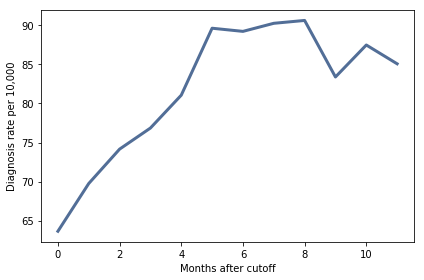

In [5]:
xs = np.arange(12)
thinkplot.plot(xs, rates)
thinkplot.decorate(xlabel='Months after cutoff',
                   ylabel='Diagnosis rate per 10,000')

For the first 9 months, from September to May, we see what we would expect if at least some of the excess diagnoses are due to behavioral differences due to age.  For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August.  This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back students born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade, and therefore less likely to be diagnosed.

We could test this hypothesis by checking the actual ages of these students when they started school, rather than just looking at their months of birth.

I'll use a beta distribution to compute the posterior credible interval for each of these rates.

In [6]:
import scipy.stats

pcount = 1
res = []
for (x, d, t) in zip(xs, diagnosed, totals):
    a = d + pcount
    b = t-d + pcount
    ci = scipy.stats.beta(a, b).ppf([0.025, 0.975])
    res.append(ci * 10000)

By transposing the results, we can get them into two arrays for plotting.

In [7]:
low, high = np.transpose(res)

In [8]:
low

array([55.88350221, 61.50636809, 65.24705555, 67.82200497, 71.91566468,
       79.7803044 , 79.8376067 , 80.83488731, 81.23383696, 74.32935962,
       78.45460029, 76.14872189])

In [9]:
high

array([ 72.49141124,  79.12409251,  84.2928591 ,  87.10526514,
        91.38514006, 100.71257892,  99.73630892, 100.8006574 ,
       101.12113503,  93.57085021,  97.56460619,  95.0639517 ])

Here's what the plot looks like with error bars.

In [10]:
import matplotlib.pyplot as plt

def errorbar(xs, low, high, **options):
    for x, l, h in zip(xs, low, high):
        plt.vlines(x, l, h, **options)

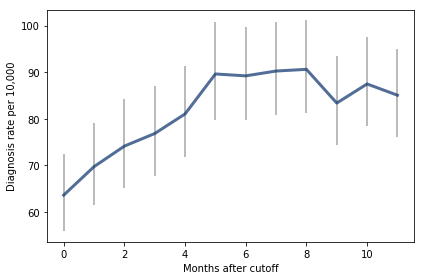

In [11]:
errorbar(xs, low, high, color='gray', alpha=0.7)
thinkplot.plot(xs, rates)
thinkplot.decorate(xlabel='Months after cutoff',
                   ylabel='Diagnosis rate per 10,000')

It seems like the lower rates in the last 3 months are unlikely to be due to random variation, so it might be good to investigate the effect of "red shirting".

But for now I will proceed with a linear logistic model.  The following table shows log odds of diagnosis for each month, which I will use to lay out a grid for parameter estimation.

In [12]:
from scipy.special import expit, logit

for (x, d, t) in zip(xs, diagnosed, totals):
    print(x, logit(d/t))

0 -5.050653410037134
1 -4.9583180838728875
2 -4.89671332938555
3 -4.860673360075637
4 -4.806955183198423
5 -4.705597122964573
6 -4.71014626293798
7 -4.698526243285876
8 -4.694439789392316
9 -4.778391224951511
10 -4.730066749295253
11 -4.758210679745176


Here's a Suite that estimates the parameters of a logistic regression model, `b0` and `b1`.

In [13]:
class August(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        x, d, t = data
        b0, b1 = hypo
        
        p = expit(b0 + b1 * x)
        like = scipy.stats.binom.pmf(d, t, p)
        
        return like

The prior distributions are uniform over a grid that covers the most likely values.

In [14]:
from itertools import product

b0 = np.linspace(-4.75, -5.1, 101)
b1 = np.linspace(-0.05, 0.05, 101)
hypos = product(b0, b1)

suite = August(hypos);

Here's the update.

In [15]:
for data in zip(xs, diagnosed, totals):
    suite.Update(data)

Here's the posterior marginal distribution for `b0`.

-4.935267063442661


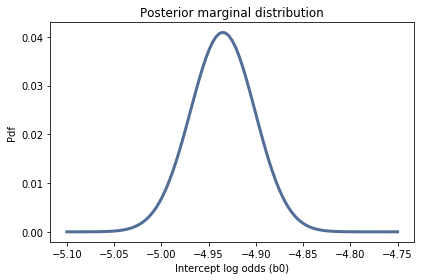

In [16]:
pmf0 = suite.Marginal(0)
b0 = pmf0.Mean()
print(b0)
thinkplot.Pdf(pmf0)

thinkplot.decorate(title='Posterior marginal distribution',
                   xlabel='Intercept log odds (b0)',
                   ylabel='Pdf')

And the posterior marginal distribution for `b1`.

0.023935981894059242


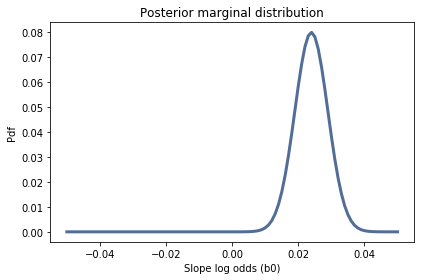

In [17]:
pmf1 = suite.Marginal(1)
b1 = pmf1.Mean()
print(b1)
thinkplot.Pdf(pmf1)

thinkplot.decorate(title='Posterior marginal distribution',
                   xlabel='Slope log odds (b0)',
                   ylabel='Pdf')

Let's see what the posterior regression lines look like, superimposed on the data.

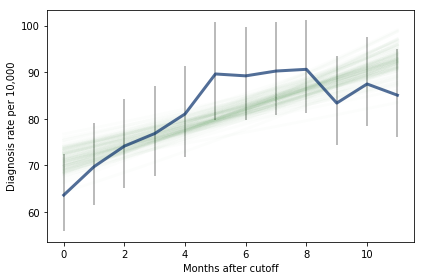

In [18]:
for i in range(100):
    b0, b1 = suite.Random()
    ys = expit(b0 + b1 * xs) * 10000
    thinkplot.plot(xs, ys, color='green', alpha=0.01)
    
errorbar(xs, low, high, color='gray', alpha=0.7)
thinkplot.plot(xs, rates)

thinkplot.decorate(xlabel='Months after cutoff',
                   ylabel='Diagnosis rate per 10,000')

Most of these regression lines fall within the credible intervals of the observed rates, so in that sense it seems like this model is not ruled out by the data.

But it is clear that the lower rates in the last 3 months bring down the estimated slope, so we should probably treat the estimated effect size as a lower bound.

To express the results more clearly, we can look at the posterior predictive distribution for the difference between a child born in September and one born in August:

In [19]:
def posterior_predictive(x):
    pmf = Pmf()

    for (b0, b1), p in suite.Items():
        base = expit(b0 + b1 * x) * 10000
        pmf[base] += p
        
    return pmf

Here are posterior predictive CDFs for diagnosis rates.

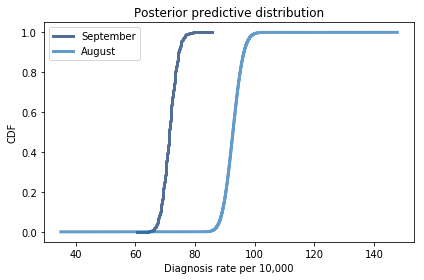

In [20]:
pmf0 = posterior_predictive(0)
thinkplot.Cdf(pmf0.MakeCdf(), label='September')

pmf1 = posterior_predictive(11)
thinkplot.Cdf(pmf1.MakeCdf(), label='August')

thinkplot.decorate(title='Posterior predictive distribution',
                   xlabel='Diagnosis rate per 10,000',
                   ylabel='CDF')

In [21]:
pmf0.Mean()

71.41299996984112

And we can compute the posterior predictive distribution for the difference.

In [22]:
def posterior_predictive_diff():
    pmf = Pmf()
    
    for (b0, b1), p in suite.Items():
        p0 = expit(b0) * 10000
        p1 = expit(b0 + b1 * 11) * 10000
        diff = p1 - p0
        pmf[diff] += p
        
    return pmf

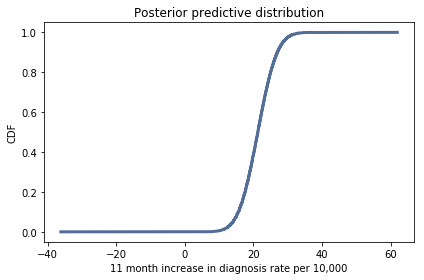

In [23]:
pmf_diff = posterior_predictive_diff()
thinkplot.Cdf(pmf_diff.MakeCdf())

thinkplot.decorate(title='Posterior predictive distribution',
                   xlabel='11 month increase in diagnosis rate per 10,000',
                   ylabel='CDF')

To summarize, we can compute the mean and 95% credible interval for this difference.

In [24]:
pmf_diff.Mean()

21.301302380532498

In [25]:
pmf_diff.CredibleInterval(95)

(12.53483625370616, 30.001082782077376)

A difference of 21 diagnoses, on a base rate of 71 diagnoses, is an increase of 30% (18%, 42%)

In [26]:
pmf_diff.Mean() / pmf0.Mean()

0.29828325920390386

In [27]:
pmf_diff.CredibleInterval(95) / pmf0.Mean()

array([0.17552597, 0.42010674])